<b style="font-size:150%;"> This script makes a statistical analysis of the hard drive disks data. <br>
</b> 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import seaborn
%matplotlib inline

In [2]:
## matplotlib settings
matplotlib.style.use('ggplot')
#plt.rcParams['figure.figsize']=16,10
plt.rcParams.update({'font.size': 12, 
                            'font.family': 'STIXGeneral', 
                            'mathtext.fontset': 'stix'})

In [3]:
# seaborn settings
seaborn.set_palette('deep', desat=.6)

In [4]:
# reading data set
data= pd.read_csv('hard_drive_data_2015.csv')
data= data.drop('Unnamed: 0', 1)

<p style= "font-size: 120%;">
Failed disks:
</p>


In [5]:
fail= pd.DataFrame(data[data.failure==1]).reset_index()
fail= fail.drop('index', 1)

<p style= "font-size: 120%;">
Success disks:
</p>



In [6]:
success= data.groupby(['serial_number']).filter(lambda x: x['failure'].sum()==0) 
succ= pd.DataFrame(success.groupby(['serial_number']).tail(n=1)).reset_index()
succ= succ.drop('index', 1)

<b style="font-size:150%;"> PART I: Quantifying difference between distributions  <br>
of failed and success disks
</b> 

<p style="font-size:120%;"> The Cohen's distance is the best measurement to quantify differences between the distributions.
</p> 



In [7]:
class Cohen_distance(object):
    '''
    Input: specific S.M.A.R.T attribute of failed and success disks
    '''
    #def __init__(self, dist1, dist2):
    #    self.dist1= dist1
    #    self.dist2= dist2

    def distance(self, dist1, dist2):
        diff= abs(dist1.mean() - dist2.mean() )
        n1, n2= len(dist1), len(dist2)
        var1, var2= dist1.var(), dist2.var()
        denominator= ((n1-1)*var1 + (n2-1)*var2)/ (n1+n2)
        d= diff/np.sqrt(denominator)
        return d

    def overlap_superiority(self, dist1, dist2):
        control_sample= dist1
        treatment_sample= dist2
        thresh = (control_sample.mean() + treatment_sample.mean()) / 2
        control_above= sum(control_sample>thresh)/len(control_sample)
        treatment_below= sum(treatment_sample <thresh)/ len(treatment_sample)
        overlap= control_above+ treatment_below
        superiority= np.size([x for x,y in zip(treatment_sample, control_sample) if x>y ])/len(treatment_sample)
        return overlap, superiority
    
    def get_effect_size(self, dist1, dist2):
        distance= self.distance(dist1, dist2)
        overl_prob, sup_prob= self.overlap_superiority(dist1, dist2)
        return distance, overl_prob, sup_prob

In [8]:
dist= []
stats= Cohen_distance()

dist.append( stats.get_effect_size(fail.smart_1_normalized.dropna(), 
                                        succ.smart_1_normalized.dropna()))
dist.append( stats.get_effect_size(fail.smart_3_raw.dropna()/1000., 
                                        succ.smart_3_raw.dropna()/1000.)) # secs
dist.append( stats.get_effect_size(fail.smart_5_raw.dropna(), 
                                        succ.smart_5_raw.dropna()))
dist.append( stats.get_effect_size(fail.smart_9_raw.dropna()/(24*365.),
                                        succ.smart_9_raw.dropna()/(24*365.))) # hours
dist.append( stats.get_effect_size(fail.smart_12_raw.dropna(),
                                        succ.smart_12_raw.dropna()))
dist.append( stats.get_effect_size(fail.smart_194_raw.dropna(),
                                        succ.smart_194_raw.dropna()))

dist= pd.DataFrame(dist, columns=['Cohens_distance', 'overlap_prob', 'superiority_prob'])

smart_attr= pd.Series(['error_rate', 'spin-up_time', 'bad_sectors_count', 'running_time', 'power_cycle_count', 'internal_temp'])
distances= pd.concat([smart_attr, dist], axis=1)
distances= distances.rename(columns={0: 'SMART_attribute'} )
distances.sort_values(by='Cohens_distance', ascending= False)

,SMART_attribute,Cohens_distance,overlap_prob,superiority_prob
2,bad_sectors_count,0.762056,1.138253,0.003433
0,error_rate,0.410918,1.076156,0.013714
1,spin-up_time,0.220474,1.038184,0.003270
3,running_time,0.095970,1.052582,0.016853
5,internal_temp,0.052604,0.968214,0.010395
4,power_cycle_count,0.033592,1.159660,0.018529


<p style="font-size:120%;"> According to these results, the SMART attributes where there is more difference between failed and success disks are: <br> 
-- the bad sectors count <br> 
-- error rate <br>
-- the spin-up time. 
</p> 



<b style="font-size:150%;"> PART II: Quantifying the precision of the measurement  <br>
of the Cohen's distances.
</b> 

<p style="font-size:120%;"> Here I will compute the 95% confidence intervals for the estimate of the Cohen's distance.
</p> 

In [9]:
class CohenSampler(Cohen_distance):
    '''
    Makes a sampling distribution of sampling distances.
    Uses Boostraap
    '''
    def resample(self, dist1, dist2):
        group1= np.random.choice(dist1, len(dist1), replace=True)
        group2= np.random.choice(dist2, len(dist2), replace=True)
        return self.distance(group1, group2)
         
    
    def compute_sample_stats(self, dist1, dist2, niters= 1000):
        sampling_dist= [self.resample(dist1, dist2) for i in range(niters)]
        return np.array(sampling_dist)
    
    
    def get_error_and_CI(self, dist1, dist2):
        sampling= self.compute_sample_stats(dist1, dist2)
        std_error= sampling.std()
        CI= np.percentile(sampling, [2.5, 97.5])
        
        return np.round(CI, 2), np.round(std_error,2)

In [10]:
stats=[]
sampling= CohenSampler()

stats.append( sampling.get_error_and_CI(fail.smart_1_normalized.dropna(), 
                                        succ.smart_1_normalized.dropna()))
stats.append( sampling.get_error_and_CI(fail.smart_3_raw.dropna()/1000., 
                                        succ.smart_3_raw.dropna()/1000.))
stats.append( sampling.get_error_and_CI(fail.smart_5_raw.dropna(), 
                                        succ.smart_5_raw.dropna()))
stats.append( sampling.get_error_and_CI(fail.smart_9_raw.dropna()/(24*365.), 
                                        succ.smart_9_raw.dropna()/(24*365.)))
stats.append( sampling.get_error_and_CI(fail.smart_12_raw.dropna(), 
                                        succ.smart_12_raw.dropna()))
stats.append( sampling.get_error_and_CI(fail.smart_194_raw.dropna(), 
                                        succ.smart_194_raw.dropna()) )
stats= pd.DataFrame(stats, columns=['95% CI', 'std_error'])


In [11]:
stats_complete= pd.concat([distances['SMART_attribute'], distances['Cohens_distance'], stats], axis= 1 )
stats_complete

,SMART_attribute,Cohens_distance,95% CI,std_error
0,error_rate,0.410918,"[0.33, 0.51]",0.04
1,spin-up_time,0.220474,"[0.15, 0.29]",0.04
2,bad_sectors_count,0.762056,"[0.58, 0.95]",0.10
3,running_time,0.095970,"[0.04, 0.15]",0.03
4,power_cycle_count,0.033592,"[0.02, 0.14]",0.05
5,internal_temp,0.052604,"[0.0, 0.11]",0.03


<p style="font-size:120%;"> As an example, the following is a plot of the sampling distribution of the error rate. The vertical gray line shows the Cohen's distance. The yellow lines, the 95% confidence interval of this measurement. 
</p> 

In [12]:
def plot_sample_stats(dist1, dist2):
    s= CohenSampler()
    distr= s.compute_sample_stats(dist1, dist2)
    cohens_d= s.distance(dist1, dist2)
    ci= np.percentile(distr, [2.5, 97.5])
    plt.hist(distr)
    plt.plot(cohens_d*np.ones(300), np.arange(300), color='0.6')
    plt.plot(ci[0]*np.ones(300), np.arange(300), color='yellow')
    plt.plot(ci[1]*np.ones(300), np.arange(300), color='yellow')
    plt.xlabel('sampling distribution')

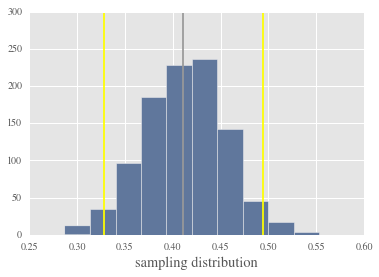

In [13]:
plot_sample_stats(fail.smart_1_normalized.dropna(),
                  succ.smart_1_normalized.dropna())

<b style="font-size:150%;"> PART III: testing if the differences observed are due to chance.  
</b> 

<p style="font-size:120%;"> Here I will make some hypothesis testing
</p> 

<p style="font-size:120%;">
My null hypothesis is: <br>
$H_0$: The distributions of S.M.A.R.T attributes 
of failed and working disks are the same. <br>

This means that: $\mu_1 -\mu_2=0$. <br>
We therefore expect that the sampling distribution of mean differences will be centered at cero. 
</p> 

In [27]:
class Hypothesis_testing(object):
    
    def distance(self, dist1, dist2):
        diff= abs(dist1.mean() - dist2.mean() )
        n1, n2= len(dist1), len(dist2)
        var1, var2= dist1.var(), dist2.var()
        denominator= ((n1-1)*var1 + (n2-1)*var2)/ (n1+n2)
        d= diff/np.sqrt(denominator)
        return d
    
    def resample_with_model(self, n, pool):
        '''
        uses bootstraap to create samples from Ho
        '''
        np.random.shuffle(pool)
        return self.distance(pool[:n], pool[n:])
    
    def test_hypothesis(self, dist1, dist2, niters=1000):
        n, m = len(dist1), len(dist2)
        pool= np.hstack((dist1, dist2))
        sampling_dist= np.array([self.resample_with_model(n, pool) for i in range(niters)] )
        observed_d= self.distance(dist1, dist2)
        p_value= sum(sampling_dist> observed_d)/len(sampling_dist)
        #plt.hist(sampling_dist)
        #plt.plot(observed_d*np.ones(300), np.arange(300), color='gray')
        return p_value
    

In [36]:
p_values=[]
test= Hypothesis_testing()

p_values.append(test.test_hypothesis(fail.smart_1_normalized.dropna(), 
                     succ.smart_1_normalized.dropna()) )
p_values.append(test.test_hypothesis(fail.smart_3_raw.dropna()/1000.,
                                    succ.smart_3_raw.dropna()/1000.))
p_values.append(test.test_hypothesis(fail.smart_5_raw.dropna(), 
                                    succ.smart_5_raw.dropna() ))
p_values.append(test.test_hypothesis(fail.smart_9_raw.dropna()/(24*365.), 
                                    succ.smart_9_raw.dropna()/(24*365.)))
p_values.append(test.test_hypothesis(fail.smart_12_raw.dropna(), 
                                    succ.smart_12_raw.dropna()))
p_values.append(test.test_hypothesis(fail.smart_194_raw.dropna(), 
                                    succ.smart_194_raw.dropna()))
p_values= pd.Series(p_values)
p_values_complete= pd.concat([distances['SMART_attribute'], distances['Cohens_distance'], p_values], axis=1)

In [37]:
p_values_complete= p_values_complete.rename(columns={0: 'p_value'})
p_values_complete

,SMART_attribute,Cohens_distance,p_value
0,error_rate,0.410918,0.000
1,spin-up_time,0.220474,0.000
2,bad_sectors_count,0.762056,0.000
3,running_time,0.095970,0.001
4,power_cycle_count,0.033592,0.072
5,internal_temp,0.052604,0.052


<p style="font-size:120%;">
With a significance of 1%, I obtain the following: <br>
- I reject $H_0$ in the first four distributions in the table of above. This means that I'm confident that the following distributions ARE DIFFERENT: <br>
  1. error rate <br>
  2. spin up time <br>
  3. bad sectors count <br>
  4. running time <br>
- I accept $H_0$ in the last two S.M.A.R.T attributes in the table. This means that the following distributions ARE THE SAME: <br>
  1. power cycle count <br>
  2. internal temperature <br>
    
</p> 